## RAG Evaluation Notebook
by Andy Garcia


For this notebook, we will use a sample HR Manual from this source:<br>
https://www.icpau.co.ug/sites/default/files/Resources/SAMPLE%20HR%20MANUAL.pdf<br>
It's already downloaded in the ./data directory.

### 1. RAG
Let's start by learning how to use Retriever Augmented Generation (RAG). There are two ways we can go about this: via the LLM's native API or via an LLM agnostic framework. We will explore using OpenAI's native API and the Langchain framework. For both cases we will use OpenAI as the LLM for generation, so you will need a working OpenAI API key. Set the environment variable using the cell below. Reminder: DO NOT upload your API KEY to Git!!!

In [ ]:
%env OPENAI_API_KEY=<YOUR API KEY HERE>

In [ ]:
import os
# Check if OPENAI_API_KEY is visible to the notebook
OPENAI_API_KEY = os.environ['OPENAI_API_KEY']
print(f'API KEY={OPENAI_API_KEY}')

In [79]:
data_folder = './data'
index_folder = './index'
document_folder = './document'

### 1.1. OpenAI API

In [78]:
# !pip install openai

In [81]:
from openai import OpenAI

client = OpenAI()
vector_store = client.beta.vector_stores.create(name="Employee Handbook",
                                                expires_after={
                                                    "anchor": "last_active_at",
                                                    "days": 1
                                                })

file_paths = [document_folder+'/SAMPLE HR MANUAL.pdf']
file_streams = [open(path, "rb") for path in file_paths]

file_batch = client.beta.vector_stores.file_batches.upload_and_poll(
    vector_store_id=vector_store.id, files=file_streams
)

print(file_batch.status)
print(file_batch.file_counts)


completed
FileCounts(cancelled=0, completed=1, failed=0, in_progress=0, total=1)


In [ ]:
# Check the vector stores uploaded
vector_stores = client.beta.vector_stores.list()
for store in vector_stores:
    print(store)

In [83]:
vector_store = vector_stores.data[0]

In [85]:
# Create an assistant

instructions = "You are an HR Assistant. If you don't have the answer from the document, refer them to directly contact HR"

assistant = client.beta.assistants.create(
  name="HR Employee Chatbot",
  instructions=instructions,
  tools=[{"type": "file_search"}],
  model="gpt-4o",
)

In [86]:
# add the vector store to the assistant

assistant = client.beta.assistants.update(
    assistant_id=assistant.id,
    tool_resources={'file_search': {'vector_store_ids': [vector_store.id]}}
)


In [88]:

# Create a thread
thread = client.beta.threads.create()

def add_message(message:str, thread=thread):
    message = client.beta.threads.messages.create(
        thread_id=thread.id,
        role="user",
        content=message
        )
    
    return message

def message_agent(message:str, instructions:str=None):
  user_messages = add_message(message)
  run = client.beta.threads.runs.create_and_poll(
          thread_id=thread.id,
          assistant_id=assistant.id,
          instructions = instructions
          )
  
  messages = client.beta.threads.messages.list(
    thread_id=thread.id
  )
  return messages

In [89]:
message = "Give a short summary of the document"
messages = message_agent(message=message)
print(messages.data[0].content[0].text.value)

The document is a Sample Human Resource Manual for ABC & Associates, a firm offering assurance and consultancy services. It outlines the guidelines for human resource management, applicable to all staff including the Senior Management Team.

1. **Purpose and Objectives**: The manual aims to guide staff regarding their rights and obligations and ensures equal employment opportunities, appropriate remuneration, fair hearing, and suitable training and facilitation【4:0†SAMPLE HR MANUAL.pdf】.

2. **Recruitment and Appointment**: It provides a recruitment policy focused on merit-based selection for positions, outlines procedures for job applications, selection tests, staff appointments, and the induction process【4:4†SAMPLE HR MANUAL.pdf】【4:3†SAMPLE HR MANUAL.pdf】.

3. **Conditions of Appointment**: Details include probation periods, termination conditions, confirmation of appointments, and the responsible use of firm resources【4:3†SAMPLE HR MANUAL.pdf】.

4. **Staff Development and Performanc

### 1.2. Langchain / LLAMA Index

Uncomment the next cell to install the required modules 

In [37]:
# ! pip install llama_index langchain langchain-openai

In [30]:
from llama_index.core import GPTVectorStoreIndex,  SimpleDirectoryReader

# from llama_index.legacy.readers.file.base import SimpleDirectoryReader

from langchain_openai import OpenAI
from llama_index.embeddings.openai import OpenAIEmbedding
from llama_index.core.node_parser import SentenceSplitter
from llama_index.llms.openai import OpenAI
from llama_index.core import Settings
from llama_index.core import StorageContext, load_index_from_storage


In [33]:
def construct_baseline_index(document_folder, index_folder):
	index_folder=index_folder+'/baseline'
	print(index_folder)
	if not os.path.exists(index_folder):
		print('CREATING')
		os.makedirs(index_folder)
	Settings.tokenizer = None
	Settings.llm = OpenAI(model="gpt-4")
	Settings.embed_model = OpenAIEmbedding(model="text-embedding-3-small")
	print('INDEXING')
	documents = SimpleDirectoryReader(document_folder).load_data()
	index =  GPTVectorStoreIndex.from_documents(documents)
	print('SAVING INDEX TO DISK')
	index.storage_context.persist(index_folder)
	return index

In [35]:
## create the index
construct_baseline_index(document_folder, index_folder)

./index/baseline
INDEXING
SAVING INDEX TO DISK


In [36]:
query = 'Give a short summary of the document'
llm_ver = 'gpt-4'
storage_context = StorageContext.from_defaults(persist_dir=index_folder+'/baseline')
index = load_index_from_storage(storage_context)
llm=OpenAI(temperature=0, model_name=llm_ver)
resp = index.as_query_engine(llm=llm).query(query).response
print(resp)

The document is a Sample Human Resource Manual that covers various aspects of human resource management policies and procedures. It includes sections on recruitment and appointment processes, conditions of appointment, staff development, performance evaluation, compensation packages, facilitation, discipline, leave policies, termination of service procedures, and safety and security measures.


### 2. LLM Evaluation
There are several ways to evaluate the performance of RAG. Here, we will explore the Langchain Evaluator Framework

### 3. LLM Evaluaion via Confusion Matrix
Now we explore using the well-known Machine Learning method. Let's load the dataset:

In [57]:
# !pip install scikit-learn

In [73]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, accuracy_score, f1_score

In [58]:
# !pip install pandas

In [47]:
import pandas as pd

filename = data_folder + '/hr_manual_dataset_binary.csv'
df = pd.read_csv(filename, header=None, names = ['query', 'label'])
df.head()

,query,label
0,What is the purpose of the HR manual at ABC & ...,True
1,How does ABC & Associates handle recruitment a...,True
2,What are the probationary terms for new employ...,True
3,How does the firm conduct performance evaluati...,True
4,What types of leave are available to employees...,True


In [48]:
X = df['query']
y = df['label']


In [45]:
X.head()

0    What is the purpose of the HR manual at ABC & ...
1    How does ABC & Associates handle recruitment a...
2    What are the probationary terms for new employ...
3    How does the firm conduct performance evaluati...
4    What types of leave are available to employees...
Name: query, dtype: object

In [46]:
y.head()

0    True
1    True
2    True
3    True
4    True
Name: label, dtype: bool

### 3.1 Langchain / LLAMA Index

In [60]:
y_predict = []

for query in X:
    prompt = f'Use only the information provided in the document. respond only with "True" if you find the answer to the query and only with "False" if not. The query is: {query}'
    # print(prompt)
    resp = index.as_query_engine(llm=llm).query(prompt).response
    print(resp)
    y_predict.append(resp)

y_predict = [s == "True" for s in y_predict]


True
True
False
True
True
True
True
True
True
True
False
False
False
False
False
False
True
False
False
False


In [74]:
precision = precision_score(y, y_predict)
recall = recall_score(y, y_predict)
accuracy = accuracy_score(y, y_predict)
f1 = f1_score(y, y_predict)
cm = confusion_matrix(y, y_predict)
print(f'Performance Evaluation for Langchain / LLAMA Index:\nprecision : {precision}\nrecall : {recall}\naccuracy : {accuracy}\nf1 score : {f1}')

Performance Evaluation for Langchain / LLAMA Index:
precision : 0.9
recall : 0.9
accuracy : 0.9
f1 score : 0.9


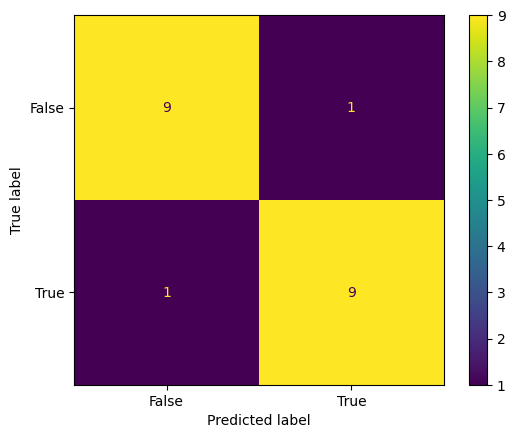

In [75]:
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])
cm_display.plot()


### 3.2 OpenAI API

In [93]:
# Create a new thread
thread = client.beta.threads.create()

y_predict_openai = []

for query in X:
    prompt = f'Use only the information provided in the document. respond only with "True" if you find the answer to the query and only with "False" if not. The query is: {query}'
    # print(prompt)
    messages = message_agent(message=prompt)
    print(messages.data[0].content[0].text.value)
    y_predict_openai.append(messages.data[0].content[0].text.value)

y_predict_openai = [s == "True" for s in y_predict_openai]

True
True
True
True
True
True
False
True
True
True
False
False
False
False
False
False
False
False
False
False


In [95]:
precision_openai = precision_score(y, y_predict_openai)
recall_openai = recall_score(y, y_predict_openai)
accuracy_openai = accuracy_score(y, y_predict_openai)
f1_openai = f1_score(y, y_predict_openai)
cm_openai = confusion_matrix(y, y_predict_openai)
print(f'Performance Evaluation for OpenAI Agent:\nprecision : {precision_openai}\nrecall : {recall_openai}\naccuracy : {accuracy_openai}\nf1 score : {f1_openai}')

Performance Evaluation for OpenAI Agent:
precision : 1.0
recall : 0.9
accuracy : 0.95
f1 score : 0.9473684210526315


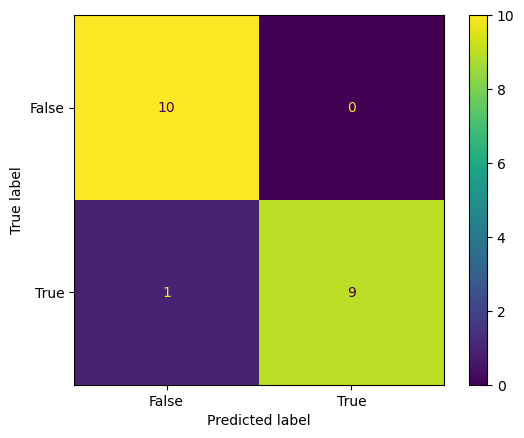

In [96]:
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm_openai, display_labels = [False, True])
cm_display.plot()